# Отток клиентов банка - описание проекта

- Из банка каждый месяц стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
- Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
- Необходимо построить модель с предельно большим значением F1-меры и довести метрику до 0.59. Также нужно проверить F1-меру на тестовой выборке
- Дополнительно измерим AUC-ROC, сравнивним её значение с F1-мерой.

## Последовательность выполнения проекта

- Загрузим и подготовим данные
- Исследуем баланс классов, обучим модель без учёта дисбаланса. Сделаем выводы.
- Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Сделаем выводы.
- Выполним финальное тестирование.

## Описание данных

**Признаки**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**

- Exited — факт ухода клиента

# Выполнение проекта

## Подготовка данных

### Загрузка и общий анализ данных

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt

try:
    data=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/06_Learning_with_teacher/Churn.csv')
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

print(data.dtypes)
print(data.info())
display(data.head())

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  fl

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Удаление пропусков

- В столбце Tenure есть пропуски - около 10% всего датасета. Относительно много, но модель обучится и без этих данных
- Удалим эти пропуски

In [2]:
data=data.dropna(subset=['Tenure'])
data['Tenure'].isna().sum()

0

### Удаление лишних столбцов

- RowNumber - просто индекс, для модели не нужен - удаляем
- Surname - фамилия - удаляем
- CustomerID - опять индекс, удаляем

In [3]:
data=data.drop(columns=['RowNumber','CustomerId','Surname'])
display(data.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Прямое кодирование

- Переведем категориальные признаки в количественные
- Чтобы избежать дамми-ловушки используем аргумент drop_first=True)

In [4]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.shape)
display(data_ohe.head())


(9091, 12)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Масштабирование признаков

- Количественные признаки имеют разный масштаб. В данном проекте мы будем исследовать модели случайного леса, решающего дерева или линейной регресси, которые не требуют масшатабирования. Однако на случай использования других моделей все равно сохраним код с маштабированием
- Выделим количественные признаки в отдельную `Series` для проведения масштабирования

In [5]:
#numeric = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts','EstimatedSalary','Balance']

#scaler = StandardScaler()
#scaler.fit(data_ohe[numeric])
#data_ohe[numeric] = scaler.transform(data_ohe[numeric])

#display(data_ohe.head())



### Разделение выборки

Разделим выборку на обучающую, тестовую и валидационную в пропорции 60:20:20

In [6]:
data_train, data_valid = train_test_split(data_ohe, test_size=0.2,train_size=0.8,random_state=123)
data_train, data_test = train_test_split(data_train, test_size=0.25,train_size=0.75,random_state=123)

print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)


(5454, 12)
(1819, 12)
(1818, 12)


### Выделение признаков

In [7]:
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

## Исследование задачи (без учета дисбаланса)

Оценим баланс классов

In [8]:
data_ohe['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

Классы несбалансированы. Попробуем обучить различные модели без учета данного фактора

### Случайный лес

- Обучим модель на тестовой выборке
- Подберем гиперпарметры на валидационной выборке
- Получим метрики на тестовой выборке

In [9]:
best_estimators_1=0
best_f1_1=0
best_model_rfc=None
for estimators in range(10, 50, 5):
    model = RandomForestClassifier(n_estimators=estimators, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_1:
        best_f1_1=f1
        best_estimators_1=estimators
        best_model_rfc=model
    print("f1 =", estimators, ":", f1)
    
print()
print('Подбор гиперпарметров')
print('best estimators=',best_estimators_1,':',best_f1_1,)

#model_core_rfc=best_model_rfc.fit(features_train, target_train)
#predicted_test=model_core_rfc.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


f1 = 10 : 0.5402843601895735
f1 = 15 : 0.5868263473053893
f1 = 20 : 0.5595054095826894
f1 = 25 : 0.5661538461538461
f1 = 30 : 0.5665634674922599
f1 = 35 : 0.5727411944869832
f1 = 40 : 0.5669781931464175
f1 = 45 : 0.5770992366412213

Подбор гиперпарметров
best estimators= 15 : 0.5868263473053893


### Решающее дерево

In [10]:
best_depth=0
best_f1_2=0
best_model_dt=None
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345) 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_2:
        best_f1_2=f1
        best_depth=depth
        best_model_dt=model
    print("f1 =", depth, ":", f1)
    

print()
print('Подбор гиперпарметров')
print('best depth=',best_depth,':',best_f1_2,)

#model_core_dt=best_model_dt.fit(features_train, target_train)
#predicted_test=model_core_dt.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))

f1 = 1 : 0.0
f1 = 2 : 0.517799352750809
f1 = 3 : 0.536741214057508
f1 = 4 : 0.5
f1 = 5 : 0.515358361774744
f1 = 6 : 0.5462962962962964
f1 = 7 : 0.5714285714285714
f1 = 8 : 0.5789473684210527
f1 = 9 : 0.5402298850574713
f1 = 10 : 0.5573770491803278
f1 = 11 : 0.5331491712707183
f1 = 12 : 0.512064343163539
f1 = 13 : 0.5148771021992238
f1 = 14 : 0.48984771573604063
f1 = 15 : 0.49692496924969254
f1 = 16 : 0.4868255959849435
f1 = 17 : 0.4893350062735257
f1 = 18 : 0.4765432098765433
f1 = 19 : 0.4911392405063291

Подбор гиперпарметров
best depth= 8 : 0.5789473684210527


### Выводы

- Были обучены модели решающего дерева и случайного дерева, подобраны соотвествующие гиперпараметры
- Зафиксированы лушчие значения метрик

## Борьба с дисбалансом. Class_weight

Попробуем обучить те же самые модели с учетом дисбаланса классов. Используем аргумент class_weight = 'balanced'

### Случайный лес

- Обучим модель на тестовой выборке c учетом балансировки
- Подберем гиперпарметры на валидационной выборке
- Получим метрики на тестовой выборке

In [11]:
best_estimators_1=0
best_f1_1=0
best_model_rfc=None
for estimators in range(10, 50, 5):
    model = RandomForestClassifier(n_estimators=estimators, random_state=12345,class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_1:
        best_f1_1=f1
        best_estimators_1=estimators
        best_model_rfc=model
        
print()
print('Подбор гиперпарметров')
print('best estimators=',best_estimators_1,':',best_f1_1,)

#core_model_rfc=best_model_rfc.fit(features_train, target_train)
#predicted_test=core_model_rfc.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best estimators= 45 : 0.5606299212598425


При таком балансировании классов метрики улучшились

### Решающее дерево

- Обучим модель на тестовой выборке c учетом балансировки
- Подберем гиперпарметры на валидационной выборке
- Получим метрики на тестовой выборке

In [12]:
best_depth=0
best_f1_2=0
best_model_dt=None
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345,class_weight = 'balanced') 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_2:
        best_f1_2=f1
        best_depth=depth
        best_model_dt=model
    

print()
print('Подбор гиперпарметров')
print('best depth=',best_depth,':',best_f1_2,)

#model_core_dt=best_model_dt.fit(features_train, target_train)
#predicted_test=model_core_dt.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best depth= 6 : 0.5931558935361217


### Выводы

- Для обоих моделей балансирование классов с помощью class_weight показало некоторое улучшение метрик

## Борьба с дисбалансом. Увеличение выборки

### Функция для увеличения выборки

In [13]:
def upsample(features, target, repeat):

    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled,random_state=12345)
    target_upsampled = shuffle(target_upsampled,random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

target_upsampled.value_counts()

(8766, 11)
(8766,)


1    4416
0    4350
Name: Exited, dtype: int64

### Случайный лес

- Обучим случайный лес на увеличенной выборке

In [14]:
best_estimators_1=0
best_f1_1=0
best_model_rfc=None
for estimators in range(10, 50, 5):
    model = RandomForestClassifier(n_estimators=estimators, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_1:
        best_f1_1=f1
        best_estimators_1=estimators
        best_model_rfc=model
        
print()
print('Подбор гиперпарметров')
print('best estimators=',best_estimators_1,':',best_f1_1,)


#core_model_rfc=best_model_rfc.fit(features_upsampled, target_upsampled)
#predicted_test=core_model_rfc.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best estimators= 45 : 0.6056338028169014


### Решаюшее дерево

- Обучим решающее дерево на увеличенной выборке

In [15]:
best_depth=0
best_f1_2=0
best_model_dt=None
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345) 
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_2:
        best_f1_2=f1
        best_depth=depth
        best_model_dt=model
    

print()
print('Подбор гиперпарметров')
print('best depth=',best_depth,':',best_f1_2,)

#model_core_dt=best_model_dt.fit(features_upsampled, target_upsampled)
#predicted_test=model_core_dt.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best depth= 6 : 0.5931558935361217


### Выводы

- Для случайного леса метрики значительно улучшись
- Для решающего дерева метрики ухудшились - методика не подходит


## Борьба с дисалансом. Уменьшение выборки

### Функция для уменьшения выборки

In [16]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

### Случайный лес

In [17]:
best_estimators_1=0
best_f1_1=0
best_model_rfc=None
for estimators in range(10, 50, 5):
    model = RandomForestClassifier(n_estimators=estimators, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_1:
        best_f1_1=f1
        best_estimators_1=estimators
        best_model_rfc=model
        
print()
print('Подбор гиперпарметров')
print('best estimators=',best_estimators_1,':',best_f1_1,)

#core_model_rfc=best_model_rfc.fit(features_downsampled, target_downsampled)
#predicted_test=core_model_rfc.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best estimators= 30 : 0.5014285714285714


### Решающее дерево

In [18]:
best_depth=0
best_f1_2=0
best_model_dt=None
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth,random_state=12345) 
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_2:
        best_f1_2=f1
        best_depth=depth
        best_model_dt=model
    

print()
print('Подбор гиперпарметров')
print('best depth=',best_depth,':',best_f1_2,)

#model_core_dt=best_model_dt.fit(features_downsampled, target_downsampled)
#predicted_test=model_core_dt.predict(features_test)
#print()
#print('Метрики на тестовой выборке')
#print("F1:", f1_score(target_test, predicted_test))
#print("ROC_auc:", roc_auc_score(target_test, predicted_test))


Подбор гиперпарметров
best depth= 2 : 0.5057096247960849


### Выводы

- Уменьшение выборки показало ухудшение метрик на всех моделях

## Тестирование модели

Наилучшие результаты показала модель случайного леса после увеличения выборки - проверим ее на тестовой выборке


Метрики на тестовой выборке
F1: 0.5842349304482226
ROC_auc: 0.8305076930171076


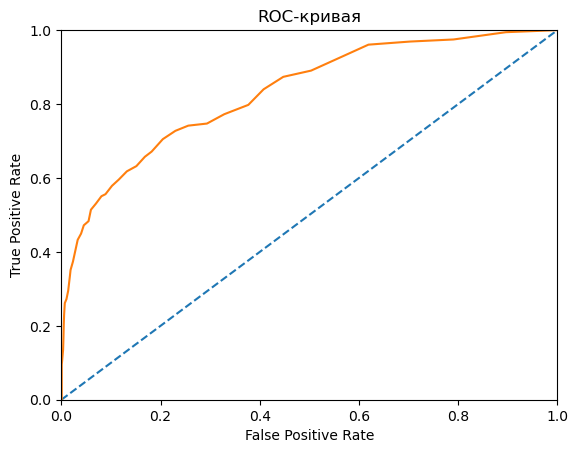

In [19]:
best_estimators_1=0
best_f1_1=0
best_model_rfc=None
for estimators in range(10, 50, 5):
    model = RandomForestClassifier(n_estimators=estimators, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1_1:
        best_f1_1=f1
        best_estimators_1=estimators
        best_model_rfc=model
        
#print()
#print('Подбор гиперпарметров')
#print('best estimators=',best_estimators_1,':',best_f1_1,)

core_model_rfc=best_model_rfc.fit(features_upsampled, target_upsampled)
predicted_test=core_model_rfc.predict(features_test)
print()
print('Метрики на тестовой выборке')
print("F1:", f1_score(target_test, predicted_test))


probabilities_test = core_model_rfc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

print("ROC_auc:", roc_auc_score(target_test, probabilities_one_test))



plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Выводы



    

- Был проведена загрузка и общий анализ данных, удалены лишние столбцы, закодированы категориальные признаки, выборка разделена на части, определен дисбаланс в данных
- Обучение моделей без учета дисбаланса показало относительно низкие значения метрики F1
- Были применены различные методы борьбы с дисбалансом (class_weight, уменьшение и увеличение выборок)
- Для каждого варианта обучения моделей были оптимизированы гиперпараметры
- Уменьшение выборки, в целом, показало худшие результаты из всех методик
- **При финальном тестировании наилучшие значения метрик F1 и ROC_AUC показала модель случайного леса с увеличением выборки в 4 раза**